# Analyze clifford experiments

In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from qbitmap import metrics 

In [3]:
# data structures
DATESTR = "20210901"
TIMESTAMP = "1630400395629"
N_EXPERIMENTS = 350

# These arrays are shape `(N_EXPERIMENTS, 4)
# First axis corresponds to which path on hardware
# second axis has four entries:
#   0: F_LE
#   1: E[F]
#   2: F0 [either with or without readout error depending on the raw vs corr]
# Third axis corresponds to which computational basis state |j> was used

results_corr = np.load(f"./results/v1_hw_{DATESTR}_clifford_line_results_corr.npy")
results_raw = np.load(f"./results/v1_hw_{DATESTR}_clifford_line_results_raw.npy")

assert results_corr.shape == (N_EXPERIMENTS, 3)

# This array is shaped `(N_EXPERIMENTS, 3)`
# The second axis is three pairs of (row, col) coordinates describing path placement
used_paths = np.load(f"./results/v1_hw_{DATESTR}_clifford_line_vs_random_paths.npy")


N_TRIALS = 5

# These arrays are shape `(N_EXPERIMENTS, N_TRIALS)`
random_results_raw = np.load(f"./results/v1_hw_{DATESTR}_random_line_results_raw.npy")
random_results_corr = np.load(f"./results/v1_hw_{DATESTR}_random_line_results_corr.npy")

assert random_results_corr.shape == (N_EXPERIMENTS, N_TRIALS)


In [4]:
from qbitmap import postprocess
import os

# Load in a `(n_experiments, 2, n_qubits)` array of single qubit bitpflips.
readout_path = os.path.join(os.getcwd(), "readout_ec")
qvals_arr = postprocess.load_qvals_arr(timestamp=TIMESTAMP, n_experiments=N_EXPERIMENTS, path=readout_path)


In [32]:
# v4 data: full sweep, but no random
BF_REJECTION = 0.15

qvals_arr = qvals_arr[:-50] # This makes me think I messed up my stitching operation

idx = postprocess.accept_by_bitflip(BF_REJECTION, qvals_arr)

# idx = idx[:-20]


x = np.arange(len(idx))
F0_corr = results_corr[idx,2]
F_corr = results_corr[idx,1]
F_LE_corr = results_corr[idx,0]
F_LE_RAND_corr = random_results_corr[idx,:]




rejected 41 events for qmax>0.15


In [19]:
import cirq
import cirq.google as cg 


def lazy_random_clifford(qubits, c=None, twoq_density=0.4, seed=None):
    """Generate a random clifford circuit, lazily.
    
    Disclaimer: This is _not_ random in the sense that it returns
    a clifford operation sampled uniformly with respect to the
    clifford group.
    
    The random sampling scheme here is admittedly half-assed.
    However I have at least guaranteed that the circuit has nontrivial
    entanglement properties
    
    Optionally provide a circuit `c` to build upon
    
    Args:
        
    """
    if seed:
        np.random.seed(seed)
    if c is None:
        c = cirq.Circuit()
    ops_1q = [cirq.H, cirq.S, cirq.X, cirq.Y]
    ops_2q = [cirq.CNOT]
    
    pairs_to_hit = [(qubits[i], qubits[i+1]) for i in range(len(qubits) - 1)]
    np.random.shuffle(pairs_to_hit)
    while len(pairs_to_hit) > 0:
        
        coinflip = np.random.random()
    
        if coinflip < twoq_density:
            # Apply a two-qubit gate
            op = np.random.choice(ops_2q)
            c += op.on(*pairs_to_hit.pop())
        else:
            # Enforce that we do not duplicate any single-qubit gates
            src = np.random.choice(range(len(qubits)))
            ops_on_q = list(c.findall_operations(predicate=lambda x: qubits[src] in x.qubits))
            op = np.random.choice(ops_1q)
            temp = [x for x in ops_1q]
            if any(ops_on_q):
                _, last_op =ops_on_q[-1]
                if last_op.gate in temp:
                    temp.remove(last_op.gate)
                    
            op = np.random.choice(temp)
            c += op.on(qubits[src])
    return c

def random_pauli_circuit(qubits):
    """A random pauli string, in circuit form."""
    out = cirq.Circuit()
    ops = [cirq.X, cirq.Y, cirq.Z]
    for q in qubits:
        out += np.random.choice(ops).on(q)
    return out

def random_cl2_by_n(qubits):
    c = cirq.Circuit()
    for q in qubits:
        basis_idx = np.random.randint(3)
        if basis_idx == 0: # Z-basis
            continue
        elif basis_idx == 1: # X-basis
            c += cirq.H.on(q)
        elif basis_idx == 2: # Y-basis
            c += cirq.inverse(cirq.S).on(q)
            c += cirq.H.on(q)
    return c

def make_rigged_clif(qubits, seed=None):
#     qubits = cirq.LineQubit.range(n)
#     S = random_cl2_by_n(qubits)
    S = cirq.Circuit(cirq.H.on_each(qubits))
    U = lazy_random_clifford(qubits, c=S, seed=seed)
    P = random_pauli_circuit(qubits)
    full = cirq.Circuit()
#     full.append(S, strategy=cirq.InsertStrategy.EARLIEST)
    full.append(U, strategy=cirq.InsertStrategy.EARLIEST)
    full.append(P, strategy=cirq.InsertStrategy.EARLIEST)
    full.append(cirq.inverse(U), strategy=cirq.InsertStrategy.EARLIEST)
#     full.append(cirq.inverse(S), strategy=cirq.InsertStrategy.EARLIEST)
    return full
template_qubits = cirq.GridQubit.rect(1, 8)
n_qubits = len(template_qubits)

clifford = make_rigged_clif(template_qubits, seed=7)
structured_circuit = cg.optimized_for_sycamore(clifford)
structured_circuit_with_measure = structured_circuit + cirq.measure(*template_qubits, key='m')
forward_depth = len(structured_circuit)

clifford_LE = clifford + cirq.inverse(clifford) + cirq.measure(*template_qubits, key='m')
# Concatenate for LE circuit _after_ compilation to hardware gates
structured_circuit_LE = cg.optimized_for_sycamore(clifford) + cg.optimized_for_sycamore(cirq.inverse(clifford)) + cirq.measure(*template_qubits, key='m')

print("FORWARDS LOGICAL CIRCUIT")
display(clifford)
print("FORWARDS LOGICAL DEPTH=", len(clifford))
display(clifford_LE)

print("FORWARDS CIRCUIT")
display(structured_circuit)
print("FORWARDS DEPTH=", forward_depth)
display(structured_circuit_LE)
print("LE DEPTH=", len(structured_circuit_LE))

# Precompute the correct final bitstring hr
wf = clifford.final_state_vector()
atol = 1e-6
loc = np.where(abs(abs(wf) - 1) < atol)[0][0]
print("Expect bitstring with idx {}".format(loc))

/home/ares/projects/qbitmap/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: cirq.google was used but is deprecated.
 it will be removed in cirq v0.14.
 Use cirq_google instead.

  


FORWARDS LOGICAL CIRCUIT


(0, 0): ───H───Y───X───S───Y───X───@───────X───────@───X───Y───S^-1───X───Y──────H───
                                   │               │
(0, 1): ───H───@───────────────────X───────Z───────X──────────────────────@──────H───
               │                                                          │
(0, 2): ───H───X───Y───X───────────────@───Z───@───────────────X──────Y───X──────H───
                                       │       │
(0, 3): ───H───────@───Y───H───X───Y───X───Y───X───Y───X───H───Y──────@──────────H───
                   │                                                  │
(0, 4): ───H───@───X───S───H───X───────────Z───────────X───H───S^-1───X───@──────H───
               │                                                          │
(0, 5): ───H───X───X───S───Y───H───X───@───Y───@───X───H───Y───S^-1───X───X──────H───
                                       │       │
(0, 6): ───H───S───────@───────────────X───X───X───────────────@──────────S^-1───H───
                       │                                       │
(0, 7): ───H───S───H───X───────────────────Y───────────────────X──────H───S^-1───H───

FORWARDS LOGICAL DEPTH= 17


(0, 0): ───H───Y───X───S───Y───X───@───────X───────@───X───Y───S^-1───X───Y──────H───H───Y───X───S───Y───X───@───────X───────@───X───Y───S^-1───X───Y──────H───M('m')───
                                   │               │                                                         │               │                                 │
(0, 1): ───H───@───────────────────X───────Z───────X──────────────────────@──────H───H───@───────────────────X───────Z───────X──────────────────────@──────H───M────────
               │                                                          │              │                                                          │          │
(0, 2): ───H───X───Y───X───────────────@───Z───@───────────────X──────Y───X──────H───H───X───Y───X───────────────@───Z───@───────────────X──────Y───X──────H───M────────
                                       │       │                                                                 │       │                                     │
(0, 3): ───H───────@───Y───H───X───Y───X───Y───X───Y───X───H───Y──────@──────────H───H───────@───Y───H───X───Y───X───Y───X───Y───X───H───Y──────@──────────H───M────────
                   │                                                  │                      │                                                  │              │
(0, 4): ───H───@───X───S───H───X───────────Z───────────X───H───S^-1───X───@──────H───H───@───X───S───H───X───────────Z───────────X───H───S^-1───X───@──────H───M────────
               │                                                          │              │                                                          │          │
(0, 5): ───H───X───X───S───Y───H───X───@───Y───@───X───H───Y───S^-1───X───X──────H───H───X───X───S───Y───H───X───@───Y───@───X───H───Y───S^-1───X───X──────H───M────────
                                       │       │                                                                 │       │                                     │
(0, 6): ───H───S───────@───────────────X───X───X───────────────@──────────S^-1───H───H───S───────@───────────────X───X───X───────────────@──────────S^-1───H───M────────
                       │                                       │                                 │                                       │                     │
(0, 7): ───H───S───H───X───────────────────Y───────────────────X──────H───S^-1───H───H───S───H───X───────────────────Y───────────────────X──────H───S^-1───H───M────────

FORWARDS CIRCUIT


(0, 0): ───PhXZ(a=0,x=0.5,z=-0.5)──────────────────────────────────────────────────────────────────────────────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=-0.5,x=0.5,z=0)────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=0.25,x=1,z=0)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                               │                                 │                                     │                                 │
(0, 1): ───PhXZ(a=-0.75,x=0,z=-0.5)────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=0,x=0.5,z=0.5)─────iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=0.5,x=0.5,z=-1)────iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=0,x=0.5,z=0.5)──────────────────────────────────────────────────────────────────────────────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=-0.5,x=0.5,z=-0.5)─────────────────────────────────────────────────────────────────────────────
                                       │                                 │                                                                                                                                                                                                                                                              │                                 │
(0, 2): ───PhXZ(a=-0.5,x=0.5,z=-0.5)───iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=-1,x=0.5,z=0.5)────────────────────────────────────────────────────────────────────────────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=0.5,x=0.5,z=-1)─────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=0,x=0.5,z=-0.5)────iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=0,x=0.5,z=-1)──────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                       │                                 │                                      │                                 │
(0, 3): ───PhXZ(a=-0.75,x=0,z=-0.5)────────────────────────────────────────────────────────────────────────────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=0.5,x=0.5,z=0)─────iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=-0.5,x=0.5,z=-1)────iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=-0.5,x=0.5,z=-1)───iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=-0.5,x=0.5,z=-0.5)─────────────────────────────────────────────────────────────────────────────
                                                                                                               │                                 │                                                                                                                                                                                      │                                 │
(0, 4): ───PhXZ(a=-0.75,x=0,z=-0.5)────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=0,x=0.5,z=0.5)─────iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=-0.5,x=0.5,z=-1)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=0,x=0.5,z=0.5)───────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=-0.5,x=0.5,z=-0.5)───
                                       │                                 │                                                                                                                                                                                                                                                                                                              

FORWARDS DEPTH= 25


(0, 0): ───PhXZ(a=0,x=0.5,z=-0.5)──────────────────────────────────────────────────────────────────────────────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=-0.5,x=0.5,z=0)────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=0.25,x=1,z=0)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhXZ(a=0,x=0.5,z=-0.5)──────────────────────────────────────────────────────────────────────────────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=-0.5,x=0.5,z=0)────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=0.25,x=1,z=0)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────M('m')───
                                                                                                               │                                 │                                     │                                 │                                                                                                                                                                                                                                                                                                                                                                      │                                 │                                     │                                 │                                                                                                                                                                                                                                                                  │
(0, 1): ───PhXZ(a=-0.75,x=0,z=-0.5)────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=0,x=0.5,z=0.5)─────iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=0.5,x=0.5,z=-1)────iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=0,x=0.5,z=0.5)──────────────────────────────────────────────────────────────────────────────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=-0.5,x=0.5,z=-0.5)─────────────────────────────────────────────────────────────────────────────PhXZ(a=-0.75,x=0,z=-0.5)────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=0,x=0.5,z=0.5)─────iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=0.5,x=0.5,z=-1)────iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=0,x=0.5,z=0.5)──────────────────────────────────────────────────────────────────────────────iSwap────────PhXZ(a=-1,x=1,z=0)───iSwap───────PhXZ(a=-0.5,x=0.5,z=-0.5)─────────────────────────────────────────────────────────────────────────────M────────
                                       │                                 │                                                                                                                                                                                                                                                              │                                 │                                                                                                                                             │                                 │                                                                                                                                                                                                                                                              │                                 │                                                                                                                 │
(0, 2): ───PhXZ(a=-0.5,x=0.5,z=-0.5)───iSwap^-0.5────────────────────────iSwap^0.5───PhXZ(a=-1,x=0.5,z=0.5)────────────────────────────────────────────────────────────────────────────iSwap────────PhXZ(a=-1,x=1,z=

LE DEPTH= 51
Expect bitstring with idx 74


TIMESTAMP: 1630400395629


 {(3, 2): Text(2.0, 3.0, '(3, 2)'),
  (4, 1): Text(1.0, 4.0, '(4, 1)'),
  (4, 2): Text(2.0, 4.0, '(4, 2)'),
  (4, 3): Text(3.0, 4.0, '(4, 3)'),
  (5, 0): Text(0.0, 5.0, '(5, 0)'),
  (5, 1): Text(1.0, 5.0, '(5, 1)'),
  (5, 2): Text(2.0, 5.0, '(5, 2)'),
  (5, 3): Text(3.0, 5.0, '(5, 3)'),
  (5, 4): Text(4.0, 5.0, '(5, 4)'),
  (6, 1): Text(1.0, 6.0, '(6, 1)'),
  (6, 2): Text(2.0, 6.0, '(6, 2)'),
  (6, 3): Text(3.0, 6.0, '(6, 3)'),
  (6, 4): Text(4.0, 6.0, '(6, 4)'),
  (6, 5): Text(5.0, 6.0, '(6, 5)'),
  (7, 2): Text(2.0, 7.0, '(7, 2)'),
  (7, 3): Text(3.0, 7.0, '(7, 3)'),
  (7, 4): Text(4.0, 7.0, '(7, 4)'),
  (7, 5): Text(5.0, 7.0, '(7, 5)'),
  (7, 6): Text(6.0, 7.0, '(7, 6)'),
  (8, 3): Text(3.0, 8.0, '(8, 3)'),
  (8, 4): Text(4.0, 8.0, '(8, 4)'),
  (8, 5): Text(5.0, 8.0, '(8, 5)'),
  (9, 4): Text(4.0, 9.0, '(9, 4)')}]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


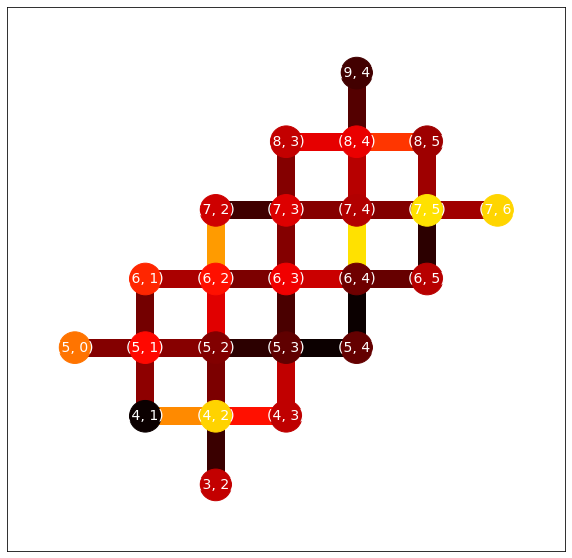

In [28]:
from qbitmap import hw, calibration_data

# Don't overwrite any of the analysis using a different processor...!
assert hw.PROCESSOR_ID == "rainbow"


# target_calibration = hw.PROCESSOR.get_current_calibration()
# TIMESTAMP = target_calibration.timestamp 
TIMESTAMP = 1630400395629
target_calibration = hw.PROCESSOR.get_calibration(TIMESTAMP // 1000)

print("TIMESTAMP:", TIMESTAMP)

# Target specifically these metrics
metric_1q = "single_qubit_rb_average_error_per_gate"
metric_2q = "two_qubit_sqrt_iswap_gate_xeb_average_error_per_cycle"
calibration = calibration_data.CalibrationWrapper(
    calibration_dct=target_calibration, 
    qubits=hw.DEVICE.qubits, 
    metric_1q=metric_1q, 
    metric_2q=metric_2q
)
fig, ax = plt.subplots(figsize=(10, 10))

calibration.plot_noise_graph(ax=ax)

In [40]:

# F0_corr = results_corr[idx,2]
F0_corr, F0_raw = metrics.recompute_F0(
    circuit=structured_circuit_LE, 
    template_qubits=template_qubits, 
    noise_graph=calibration.noise_graph, 
    paths=used_paths, 
    c1q=2, c2q=1.33
)
F0_corr = F0_corr[idx]


In [41]:
from qbitmap.metrics import bootstrap_metric
from scipy.stats import kendalltau


FLE_rand_corr_mean = F_LE_RAND_corr.mean(axis=1)


def tau_b(x, y):
    return kendalltau(x, y)[0]

# Random performance
FLE_rand_corr_err = F_LE_RAND_corr.std(axis=1) 
FLE_rand_corr_mean = F_LE_RAND_corr.mean(axis=1)

ntrials = 10_000

tau_FLE = bootstrap_metric(tau_b, F_LE_corr, F_corr, ntrials=ntrials)
tau_FLE_rand = bootstrap_metric(tau_b, FLE_rand_corr_mean, F_corr, ntrials=ntrials)
tau_F0 = bootstrap_metric(tau_b, F0_corr, F_corr, ntrials=ntrials)

print("FLE", tau_b(F_LE_corr, F_corr), np.std(tau_FLE))
print("FLE_r", tau_b(FLE_rand_corr_mean, F_corr), np.std(tau_FLE_rand))
print("F0", tau_b(F0_corr, F_corr), np.std(tau_F0))

FLE 0.5616488774383512 0.03273369047876298
FLE_r 0.5392896577107105 0.03164686629916771
F0 0.1050791313949209 0.04507188446365537


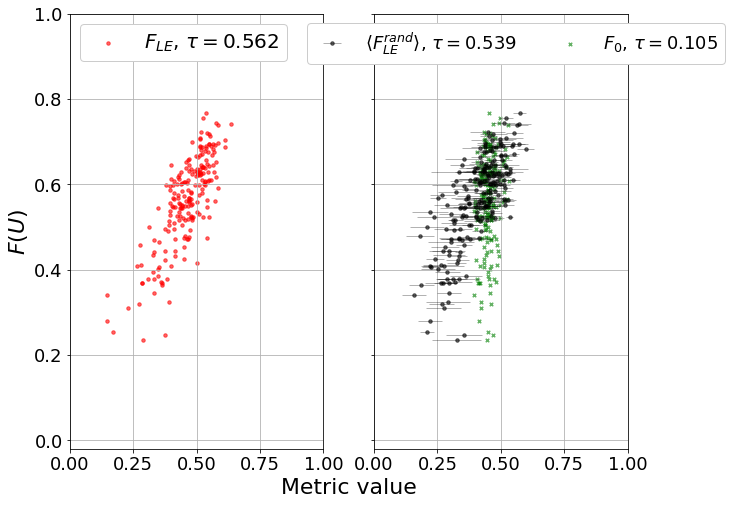

In [42]:
from scipy.stats import spearmanr, kendalltau

plt.style.use('../../style.mplstyle')
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharey=True, sharex=True, constrained_layout=False)

s = 12 # dotsize
alpha = 0.6


# Random performance
FLE_rand_corr_err = F_LE_RAND_corr.std(axis=1) 
FLE_rand_corr_mean = F_LE_RAND_corr.mean(axis=1)

# Compute correlation coefficients
r_FLE_F = kendalltau(F_LE_corr, F_corr)[0]
r_FLE_rand_F = kendalltau(FLE_rand_corr_mean, F_corr)[0] 
r_F0_F = kendalltau(F0_corr, F_corr)[0]

axes[1].errorbar(
    FLE_rand_corr_mean, 
    F_corr.flatten(), 
    xerr=FLE_rand_corr_err, linestyle="None", 
    label=r"$\langle F_{LE}^{rand}\rangle$, $\tau=$" + "{:2.3f}".format(r_FLE_rand_F),
    marker='o', 
    c='k', 
    markersize=np.sqrt(s), 
    alpha=alpha, 
    lw=.5)


axes[0].scatter(F_LE_corr.flatten(), F_corr.flatten(), label=r"$F_{LE}$, $\tau=$"+ "{:2.3f}".format(r_FLE_F), marker='o', c='r', alpha=alpha, s=s)
axes[1].scatter(F0_corr.flatten(), F_corr.flatten(), label=r"$F_0$, $\tau=$"+ "{:2.3f}".format(r_F0_F), marker='x', c='g', alpha=alpha, s=s)


axes[0].set_ylabel(r"$F(U)$", size=22)
xax = fig.add_subplot(111, frameon=False)
xax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
xax.set_xlabel('Metric value', size=22)

for ax in axes:
    ax.grid(True)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, 1)

h1, l1 = axes[0].get_legend_handles_labels()
h2, l2 = axes[1].get_legend_handles_labels()

# Centered right config
legloc="lower right"
axes[0].legend(h1, l1,  prop={"size": 20}, loc="upper left", framealpha=1, bbox_to_anchor = (0, 1.0))
axes[1].legend(h2[::-1], l2[::-1], prop={"size": 18}, loc="upper left", framealpha=1, bbox_to_anchor = (-.3, 1.0),ncol=2)




# fig.savefig("../../figures/v6_rainbow_ghz_F0_FLE_FRAND_scatter_corr.pdf",bbox_inches='tight')

In [ ]:
from qbitmap import postprocess

parr = np.linspace(75, 95, 21)

x1 = [postprocess.Y_gt_y_X_gt_X_conditional(FLE_rand_corr_mean, F_corr, percentile) for percentile in parr]
x2 = [postprocess.Y_gt_y_X_gt_X_conditional(F_LE_corr, F_corr, percentile) for percentile in parr]
x3 = [postprocess.Y_gt_y_X_gt_X_conditional(F0_corr, F_corr, percentile) for percentile in parr]
x4 = 1 - parr/100
plt.plot(parr, x1, label=r"$\langle F_{LE}^{rand}\rangle$", c='k', alpha=0.9)
plt.plot(parr, x2, label=r"$F_{LE}$", c='r')
plt.plot(parr, x3, label=r"$F_0$", c='g')
plt.plot(parr, x4, label="Guess", ls='--', c='k')
plt.grid()
plt.ylim(0, 1)
# plt.plot(1-np.asarray(x3)*100, np.asarray(x3), label="bench")
plt.ylabel(r"Conditional success $P(Y_k | X_k)$")
plt.xlabel(r"Percentile cutoff $k$")
plt.legend(loc="center", bbox_to_anchor=(1.2, 0.5), framealpha=1)
# plt.savefig("../../figures/v6_rainbow_ghz_F0_FLE_FRAND_cutoff_test.pdf",bbox_inches='tight')

In [10]:
percentile = 80
print("FLE_rand vs F")
print(postprocess.Y_gt_y_X_gt_X_conditional(FLE_rand_corr_mean, F_corr, percentile))

print("FLE vs F")
print(postprocess.Y_gt_y_X_gt_X_conditional(F_LE_corr, F_corr, percentile))

print("F0 vs F")
print(postprocess.Y_gt_y_X_gt_X_conditional(F0_corr, F_corr, percentile))

FLE_rand vs F
0.5098039215686274
FLE vs F
0.6078431372549019
F0 vs F
0.3333333333333333


## Repeat analysis for no error correction

In [11]:
# v4 data: full sweep, but no random
BF_REJECTION = 0.15

idx = postprocess.accept_by_bitflip(BF_REJECTION, qvals_arr)
x = np.arange(len(idx))
F0_raw = results_raw[idx,2]
F_raw = results_raw[idx,1]
F_LE_raw = results_raw[idx,0]
F_LE_RAND_raw = random_results_raw[idx,:]


rejected 44 events for qmax>0.15


Text(0, 0.5, '$F(U)$')

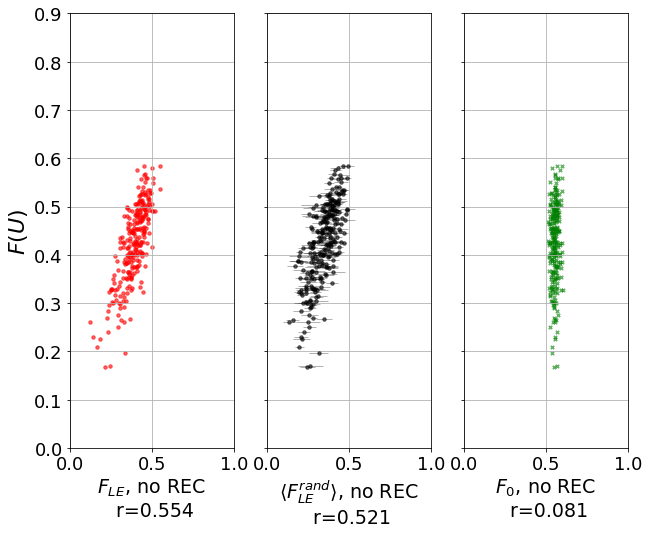

In [12]:

fig, axes = plt.subplots(1, 3, figsize=(10, 8), sharey=True)

s = 12 # dotsize
alpha = 0.6

# Random performance
FLE_rand_raw_err = F_LE_RAND_raw.std(axis=1) 
FLE_rand_raw_mean = F_LE_RAND_raw.mean(axis=1)

# Compute correlation coefficients
r_FLE_F_raw = kendalltau(F_LE_raw, F_raw)[0]
r_FLE_rand_F_raw = kendalltau(FLE_rand_raw_mean, F_raw)[0] 
r_F0_F_raw = kendalltau(F0_raw, F_raw)[0]

axes[1].errorbar(
    FLE_rand_raw_mean, 
    F_raw.flatten(), 
    xerr=FLE_rand_raw_err, linestyle="None", 
    label=r"$\langle F_{LE}^{rand}\rangle$" + ": r={:2.3f}".format(r_FLE_rand_F_raw),
    marker='o', 
    c='k', 
    markersize=np.sqrt(s), 
    alpha=alpha, 
    lw=.5)

# axes[1].errorbar(
#     FLE_rand_corr_mean, 
#     F_corr.flatten(), 
#     xerr=FLE_rand_corr_err, linestyle="None", 
# #     label=r"$\langle F_{LE}^{rand}\rangle$" + ": r={:2.3f}".format(r_FLE_rand_F_raw),
#     marker='o', 
#     c='c', 
#     markersize=np.sqrt(s), 
#     alpha=alpha, 
#     lw=.5)

axes[0].scatter(F_LE_raw.flatten(), F_raw.flatten(), label=r"$F_{LE}$"+ ": r={:2.3f}".format(r_FLE_F_raw), marker='o', c='r', alpha=alpha, s=s)
# axes[0].scatter(F_LE_corr.flatten(), F_corr.flatten(), label=r"$F_{LE}$"+ ": r={:2.3f}".format(r_FLE_F_raw), marker='o', c='c', alpha=alpha, s=s)
axes[2].scatter(F0_raw.flatten(), F_raw.flatten(), label=r"$F_0$"+ ": r={:2.3f}".format(r_F0_F_raw), marker='x', c='g', alpha=alpha, s=s)



for i, ax in enumerate(axes):
    ax.grid(True)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.9)

# h1, l1 = axes[0].get_legend_handles_labels()
# h2, l2 = axes[1].get_legend_handles_labels()

axes[0].set_xlabel(r"$F_{LE}$, no REC" + "\n r={:2.3f}".format(r_FLE_F_raw))
axes[1].set_xlabel(r"$\langle F_{LE}^{rand}\rangle$, no REC" + "\n r={:2.3f}".format(r_FLE_rand_F_raw))
axes[2].set_xlabel(r"$F_{0}$, no REC" + "\n r={:2.3f}".format(r_F0_F_raw))
axes[0].set_ylabel(r"$F(U)$", size=22)




# PRODUCTION PLOT

In [13]:
from qbitmap import postprocess

parr = np.linspace(75, 95, 21)

x1 = np.asarray([postprocess.Y_gt_y_X_gt_X_conditional(FLE_rand_corr_mean, F_corr, percentile) for percentile in parr])
x1_err = np.asarray([
    np.std(bootstrap_metric(postprocess.Y_gt_y_X_gt_X_conditional, FLE_rand_corr_mean, F_corr, percentile, ntrials=1000))
        for percentile in parr
])


x2 = np.asarray([postprocess.Y_gt_y_X_gt_X_conditional(F_LE_corr, F_corr, percentile) for percentile in parr])
x2_err = np.asarray([
    np.std(bootstrap_metric(postprocess.Y_gt_y_X_gt_X_conditional, F_LE_corr, F_corr, percentile, ntrials=1000))
        for percentile in parr
])

x3 = np.asarray([postprocess.Y_gt_y_X_gt_X_conditional(F0_corr, F_corr, percentile) for percentile in parr])
x3_err = np.asarray([
    np.std(bootstrap_metric(postprocess.Y_gt_y_X_gt_X_conditional, F0_corr, F_corr, percentile, ntrials=1000))
        for percentile in parr
])

x4 = 1 - parr/100


/home/ares/projects/qbitmap/lib/python3.6/site-packages/ipykernel_launcher.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


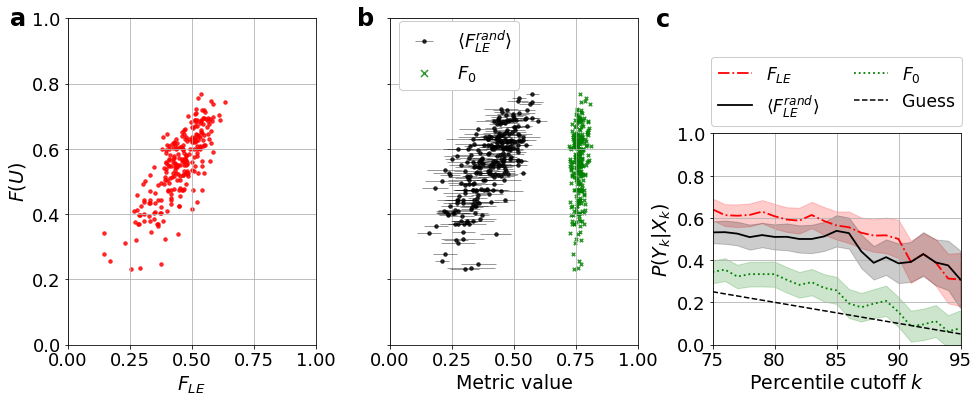

In [14]:
plt.style.use('../../style.mplstyle')
from scipy.stats import kendalltau


fig = plt.figure(figsize=(16, 6))

gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.3)
ax0 = fig.add_subplot(gs[0:3,0])
ax1 = fig.add_subplot(gs[0:3,1], sharey=ax0)
ax2 = fig.add_subplot(gs[1:3,2])
ax3 = fig.add_subplot(gs[1, 1])



plt.style.use('../../style.mplstyle')
s = 12 # dotsize
alpha = 0.8


# Random performance
FLE_rand_corr_err = F_LE_RAND_corr.std(axis=1) 
FLE_rand_corr_mean = F_LE_RAND_corr.mean(axis=1)

# Compute correlation coefficients
r_FLE_F = kendalltau(F_LE_corr, F_corr)[0]
r_FLE_rand_F = kendalltau(FLE_rand_corr_mean, F_corr)[0] 
r_F0_F = kendalltau(F0_corr, F_corr)[0]

ax0.scatter(F_LE_corr.flatten(), F_corr.flatten(), label=r"$F_{LE}$", marker='o', c='r', alpha=alpha, s=s)

ax1.errorbar(
    FLE_rand_corr_mean, 
    F_corr.flatten(), 
    xerr=FLE_rand_corr_err, linestyle="None", 
#     label=r"$\langle F_{LE}^{rand}\rangle$, $\tau=$" + "{:2.3f}".format(r_FLE_rand_F),
    label=r"$\langle F_{LE}^{rand}\rangle$",
    marker='o', 
    c='k', 
    markersize=np.sqrt(s), 
    alpha=alpha, 
    lw=.5)


ax1.scatter(F0_corr.flatten(), F_corr.flatten(), label=r"$F_0$", marker='x', c='g', alpha=alpha, s=s)
ax1.set_xlabel("Metric value")

# ax0.set_ylabel(r"$F(U)$", size=22)
# xax = fig.add_subplot(111, frameon=False)
# xax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# xax.set_xlabel('Metric value', size=22)

for ax in [ax0, ax1]:
    ax.grid(True)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
plt.setp(ax1.get_yticklabels(), visible=False)

h1, l1 = ax0.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()

# Centered right config
legloc="lower right"
# ax0.legend(h1, l1,  prop={"size": 18}, loc="lower right", framealpha=1)
leg1 = ax1.legend(h2[::-1], l2[::-1], prop={"size": 18}, loc="upper left", framealpha=1, bbox_to_anchor = (0, 1.02),ncol=1)
#change the marker size manually for both lines
for handle in leg1.legendHandles:
    handle._sizes = [50]
ax0.set_ylabel("$F(U)$")
ax0.set_xlabel("$F_{LE}$")



percentiles_lw = 1.8
ax2.fill_between(parr, x2 -x2_err, x2 + x2_err, color='r', alpha=0.2)
ax2.fill_between(parr, x1 -x1_err, x1 + x1_err, color='k', alpha=0.2)
ax2.fill_between(parr, x3 -x3_err, x3 + x3_err, color='g', alpha=0.2)

ax2.plot(parr, x2, label=r"$F_{LE}$", color='r', alpha=1, ls='-.', lw=percentiles_lw)
ax2.plot(parr, x1, label=r"$\langle F_{LE}^{rand}\rangle$", color='k', alpha=1, ls='-', lw=percentiles_lw)
ax2.plot(parr, x3, label=r"$F_0$", color='g', alpha=1, ls=':', lw=percentiles_lw)
ax2.plot(parr, x4, label="Guess", ls='--', c='k')

ax2.grid()
ax2.set_ylim(0, 1)
ax2.set_xlim(min(parr), max(parr))
ax2.set_ylabel(r"$P(Y_k | X_k)$")
ax2.set_xlabel(r"Percentile cutoff $k$")
ax2.legend(loc="center", bbox_to_anchor=(0.5, 1.2), framealpha=1, ncol=2)

ax3.axis('off')

# cAPTION
ax0.text(-0.2, 1, r"a", horizontalalignment='center', verticalalignment='center', size=24, transform=ax0.transAxes, weight="bold")
ax1.text(-0.1, 1, r"b", horizontalalignment='center', verticalalignment='center', size=24, transform=ax1.transAxes, weight="bold")
ax2.text(-0.2, 1.54, r"c", horizontalalignment='center', verticalalignment='center', size=24, transform=ax2.transAxes, weight="bold")



plt.tight_layout()

# DRAFT
import os
DRAFT = True
if DRAFT:
#     ax1.text(-.5,1.1, os.getcwd() + "/v6_reservation_ghz_line_DFE_vs_random_analysis.ipynb", color='red', horizontalalignment='left', verticalalignment='center', size=12, transform=ax.transAxes, weight="bold")
    fig.savefig("../../figures/cliffconj_results.pdf",bbox_inches='tight')


In [15]:
percentile = 85
idx = np.where(parr == percentile)[0][0]


ax2.plot(parr, x2, label=r"$F_{LE}$", color='r', alpha=1, ls='-.', lw=percentiles_lw)
ax2.plot(parr, x1, label=r"$\langle F_{LE}^{rand}\rangle$", color='k', alpha=1, ls='-', lw=percentiles_lw)
ax2.plot(parr, x3, label=r"$F_0$", color='g', alpha=1, ls=':', lw=percentiles_lw)
ax2.plot(parr, x4, label="Guess", ls='--', c='k')


print("FLE_rand vs F")
print(x1[idx], "std: ", x1_err[idx])

print("FLE vs F")
print(x2[idx], "std: ", x2_err[idx])

print("F0 vs F")
print(x3[idx], "std: ", x3_err[idx])

FLE_rand vs F
0.5384615384615384 std:  0.07420555381389483
FLE vs F
0.5641025641025641 std:  0.06631201954228728
F0 vs F
0.2564102564102564 std:  0.06402947304191904
